╔═════════════╦═══════════╦═════════════╦═════════════╗
║ Epoch:    0 ║ Turn:  10 ║ Loss:  None ║ Reward:  10 ║
╚═════════════╩═══════════╩═════════════╩═════════════╝


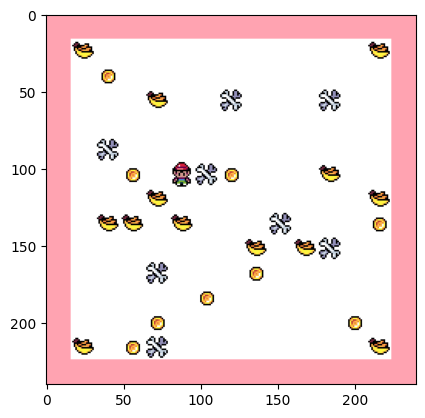

Please try again. Possible actions are below.
[0 1 2 3]


UnboundLocalError: cannot access local variable 'action' where it is not associated with a value

In [ ]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.RPG.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities
)
config_path = '../configs/config.yaml'
from examples.RPG import agents, entities
from examples.RPG.env import RPG
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = RPG(cfg, agents, entities)

for agent in agents:
    agent.model = human_player.ModelHumanPlayer(action_space=4, state_size = cfg.model.iqn.parameters.state_size, memory_size=1)

for epoch in range(cfg.experiment.epochs):
    # Reset the environment at the start of each epoch
        env.reset()
        for agent in env.agents:
            agent.reset()
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        done = 0 
        turn = 0
        losses = 0
        game_points = 0

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            scores.pretty_print(
                 'jupyter-mode',
                 epoch = epoch,
                 turn = turn,
                 reward = game_points
            )
            plt.imshow(img.astype(int))
            plt.show()



            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                agent.episode_memory.append(exp)

                game_points += reward